In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn import model_selection
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from yellowbrick.features import RFECV
from sklearn.model_selection import GridSearchCV
from yellowbrick.features import FeatureImportances
import joblib

In [2]:
data=pd.read_csv('../raw_data/houses_Madrid.csv')

In [3]:
data.head(3)

,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,False,True,False,False
1,1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#let's use id as index and drop the Unnamed column which only has a row count
data.set_index('id', inplace=True)
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head(3)

,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,longitude,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
id,,,,,,,,,,,,,,,,,,,,,
21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,False,True,False,False
21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,NaN,NaN,...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#we're about to start modifying the data, so let's do our train_test_split now:
df, test_set=train_test_split(data, test_size=.2,random_state=42)

In [6]:
#let's see the number of entries and an overview of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17393 entries, 19795 to 5947
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         17393 non-null  object 
 1   subtitle                      17393 non-null  object 
 2   sq_mt_built                   17297 non-null  float64
 3   sq_mt_useful                  6563 non-null   float64
 4   n_rooms                       17393 non-null  int64  
 5   n_bathrooms                   17383 non-null  float64
 6   n_floors                      1114 non-null   float64
 7   sq_mt_allotment               1116 non-null   float64
 8   latitude                      0 non-null      float64
 9   longitude                     0 non-null      float64
 10  raw_address                   13013 non-null  object 
 11  is_exact_address_hidden       17393 non-null  bool   
 12  street_name                   12648 non-null  object 
 13

In [7]:
#there's two potential targets: buy price and rent price. let's check them out in order to decide:
target_buy = df[df['is_buy_price_known']==True]['buy_price']
target_buy.describe()

count    1.739300e+04
mean     6.512243e+05
std      7.893974e+05
min      3.600000e+04
25%      1.980000e+05
50%      3.700000e+05
75%      7.554000e+05
max      8.800000e+06
Name: buy_price, dtype: float64

In [8]:
target_rent = df[df['is_rent_price_known']==True]['rent_price']
target_rent.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: rent_price, dtype: float64

In [9]:
#there's no rent_price, so let's get rid of it and make another overview of the columns:
df.drop(columns=['rent_price','is_rent_price_known'], inplace=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sq_mt_built,17297.0,145.889403,132.455117,13.0,70.0,100.0,160.0,999.0
sq_mt_useful,6563.0,102.757428,86.539413,1.0,59.0,79.0,111.0,998.0
n_rooms,17393.0,2.999540,1.505548,0.0,2.0,3.0,4.0,24.0
n_bathrooms,17383.0,2.083185,1.401171,1.0,1.0,2.0,2.0,16.0
n_floors,1114.0,3.155296,0.890266,1.0,3.0,3.0,4.0,7.0
sq_mt_allotment,1116.0,245.475806,246.639532,1.0,2.0,242.0,354.0,997.0
latitude,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
longitude,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
portal,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
door,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#do we have duplicated values?
df.duplicated().sum()

115

In [11]:
#let's get rid of them:
df = df.drop_duplicates()

In [12]:
#there seems to be columns with missing values. let's check them out:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
portal,17278,1.000000
latitude,17278,1.000000
has_private_parking,17278,1.000000
are_pets_allowed,17278,1.000000
has_public_parking,17278,1.000000
is_kitchen_equipped,17278,1.000000
longitude,17278,1.000000
rent_price_by_area,17278,1.000000
is_furnished,17278,1.000000
door,17278,1.000000


In [13]:
#for the moment let's get rid of the ones that are 100% na because there's nothing to do about it:
df.drop(columns=['portal','latitude','has_private_parking','are_pets_allowed','is_kitchen_equipped','longitude','longitude','rent_price_by_area','is_furnished','door'], inplace=True)

In [14]:
#we can also get rid of another column: is_buy_price_known. but before that let's filter our data by this:
df = df[df['is_buy_price_known']==True]
df.drop(columns=['is_buy_price_known'], inplace=True)

In [15]:
#there's columns we can also get rid of: the ones that by definition won't help us get an estimate:
df.drop(columns=['title','street_number','street_name','raw_address','is_exact_address_hidden'], inplace=True)

/tmp/ipykernel_32548/1868481783.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_buy);
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

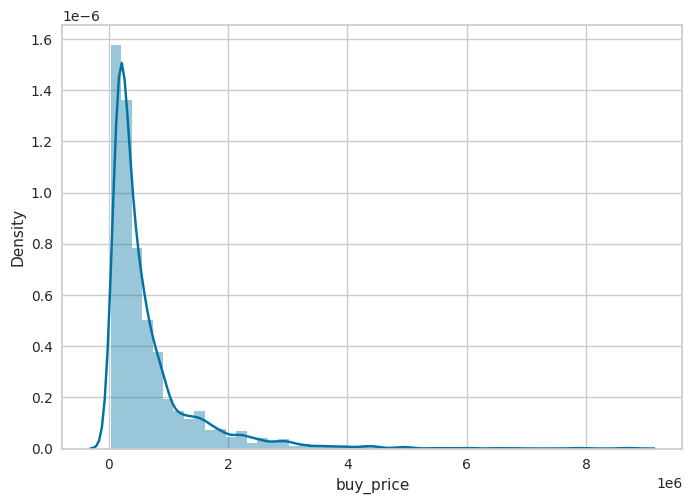

In [16]:
#now that we have target and that the dataset is a bit more manageable let's analyze a little bit the target and see how it relates to the other columns.
#how the target looks like:
sns.distplot(target_buy);

In [17]:
#the distribution of target variable is not normal,and it has a positive skew.
print("Skewness: %f" % target_buy.skew())
print("Kurtosis: %f" % target_buy.kurt())

Skewness: 3.489879
Kurtosis: 18.766340


/tmp/ipykernel_32548/2327740622.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Aria

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

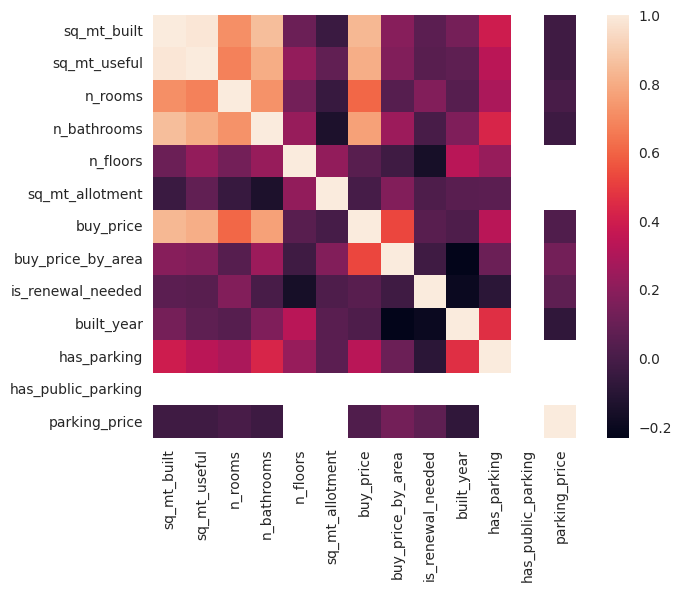

In [18]:
#let's do an initial correlation matrix:
corrmat = df.corr()
sns.heatmap(corrmat, square=True);

In [19]:
#earlier we got rid of columns that were 100% NaN, but there still are columns with NaN. we will have to decide what to do with them, so it is a good idea to check their contents:
for col in df:
    print(col)
    print(df[col].value_counts())
    print("-----------------------------------------")

subtitle
Chamartín, Madrid                           691
Moncloa, Madrid                             607
Chamberí, Madrid                            473
Centro, Madrid                              428
Hortaleza, Madrid                           379
                                           ... 
Horcajo, Madrid                               8
Barajas, Madrid                               6
Campo de las Naciones-Corralejos, Madrid      4
Casco Histórico de Barajas, Madrid            3
Timón, Madrid                                 3
Name: subtitle, Length: 145, dtype: int64
-----------------------------------------
sq_mt_built
70.0     404
60.0     385
80.0     334
65.0     300
75.0     294
        ... 
606.0      1
672.0      1
595.0      1
665.0      1
462.0      1
Name: sq_mt_built, Length: 646, dtype: int64
-----------------------------------------
sq_mt_useful
70.0     227
60.0     183
80.0     179
90.0     162
65.0     157
        ... 
395.0      1
291.0      1
297.0      1
457.0  

In [20]:
#Since 'operation' only has one value (sale) it makes no sense to keep it, we can remove it:
df.drop(columns=['operation'], inplace=True)

In [21]:
#has_public_parking is completely empty so we get rid of it:
df.drop(columns=['has_public_parking'], inplace=True)

In [22]:
#the columns below have either True or NaN, so it is very likely the NaNs are False, therefore we replace them:
nan_is_false=["has_garden","has_ac","has_fitted_wardrobes", "has_garden", "has_pool", "has_terrace", "has_balcony", "has_storage_room", "is_accessible", "has_green_zones", ]
for column in nan_is_false:
    df[column]=df[column].fillna(False)

In [23]:
#let's check missing values again
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
n_floors,16166,0.935641
sq_mt_allotment,16163,0.935467
is_parking_included_in_price,11141,0.644808
parking_price,11141,0.644808
sq_mt_useful,10746,0.621947
built_year,9305,0.538546
is_orientation_east,8265,0.478354
is_orientation_north,8265,0.478354
is_orientation_south,8265,0.478354
is_orientation_west,8265,0.478354


In [24]:
#sq_mt_allotment has many values missing. same with sq_mt_useful. sq_m_built gives similar information and there are not many missing values so we will get rid of the other two.
#same with parking_price and is_parking_included_in_price. we will only use has_parking_included.
df.drop(columns=['sq_mt_allotment','sq_mt_useful','parking_price','is_parking_included_in_price','n_floors',], inplace=True)

In [25]:
#and another check of missing data:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
built_year,9305,0.538546
is_orientation_east,8265,0.478354
is_orientation_south,8265,0.478354
is_orientation_west,8265,0.478354
is_orientation_north,8265,0.478354
has_central_heating,6460,0.373886
has_individual_heating,6460,0.373886
is_exterior,2395,0.138616
floor,2042,0.118185
has_lift,1866,0.107999


In [26]:
#let's do a final trim. by order:
#-built_year has many missing values, but we will keep it for the moment for the is_new_development column (if it has built_year we can put False)
#-is_orientation_east, is_orientation_north, is_orientation_west, is_orientation_south: there's no way to find out the orientation for the many missing values, so we get rid of them.
#-has_central_heating and has_individual_heating: we are missing many values.most homes in Madrid have heating, and it doesn't matter much whether its central or individual, so we get rid of them.
#-is_exterior is quite a critical thing for appartments, we'll decide later how to fill them out.
#subtitle is the same as neighborhood_id, so let's drop that too
#-floor is missing many values and we're not able to tell, so we get rid of it. is_floor_under doesn't seem very rellevant either so we trim it too.
#-has_lift, is_new_development, house_type_id, sq_mt_built, n_bathrooms we'll decide how to treat them later.
#lastly, if we are trying to guess the price, it is a bad idea to keep buy_pruce_by_area, it is too correlated. so we get rid of this one too.
df.drop(columns=['is_orientation_east','is_orientation_south','is_orientation_west','is_orientation_north','has_individual_heating','has_central_heating','floor','is_floor_under','buy_price_by_area', 'subtitle'], inplace=True)

In [27]:
#let's check how many columns are left:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17278 entries, 19795 to 5947
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sq_mt_built           17182 non-null  float64
 1   n_rooms               17278 non-null  int64  
 2   n_bathrooms           17268 non-null  float64
 3   neighborhood_id       17278 non-null  object 
 4   buy_price             17278 non-null  int64  
 5   house_type_id         16973 non-null  object 
 6   is_renewal_needed     17278 non-null  bool   
 7   is_new_development    16480 non-null  object 
 8   built_year            7973 non-null   float64
 9   has_ac                17278 non-null  bool   
 10  has_fitted_wardrobes  17278 non-null  bool   
 11  has_lift              15412 non-null  object 
 12  is_exterior           14883 non-null  object 
 13  has_garden            17278 non-null  bool   
 14  has_pool              17278 non-null  bool   
 15  has_terrace     

In [28]:
#these are the columns with still some missing values: is_exterior, has_lift, built_year, is_new_development, house_type_id, sq_mt_built, n_bathrooms.
#we'll start with is_exterior and has_lift. These two are attributes specially rellevant for appartments.
#therefore, it is likely that the house type that misses these attributes are "Casa o Chalet". Let's check this out:

df_house_type = df.groupby(by='house_type_id')
df_house_type['is_exterior'].describe()

,count,unique,top,freq
house_type_id,,,,
HouseType 1: Pisos,13254,2,True,11957
HouseType 2: Casa o chalet,0,0,NaN,NaN
HouseType 4: Dúplex,529,2,True,498
HouseType 5: Áticos,810,2,True,799


In [29]:
df_house_type['has_lift'].describe()

,count,unique,top,freq
house_type_id,,,,
HouseType 1: Pisos,13760,2,True,10445
HouseType 2: Casa o chalet,0,0,NaN,NaN
HouseType 4: Dúplex,531,2,True,444
HouseType 5: Áticos,820,2,True,767


In [30]:
#as expected, when it comes to House Type "Casa o chalet " the has_lift and is_exterior attributes are NaN.
#We want to manage that, but it will be easier after one-hot encoding Housetype, which is something we want to do for our model.
#Firstly tho, we will fill the blanks with another category: "miscelaneous"
#this very same category will be the one we drop once we hot-encode. The reason for that is that otherwise these columns would be fully interdependent
df['house_type_id']=df['house_type_id'].fillna("miscelaneous")
df=pd.get_dummies(df,columns=['house_type_id'])
df.drop(columns='house_type_id_miscelaneous', inplace=True)

In [31]:
#now that we got that: for exterior and lift it will stay as nan to casa o chalet and we will fill with the mode to the rest of house types
es_casa_duda_ascensor=(df['has_lift'].isnull()) & (df['house_type_id_HouseType 2: Casa o chalet']==0)
liftmode=df['has_lift'].mode()[0]
df['has_lift'][es_casa_duda_ascensor]=liftmode

/tmp/ipykernel_32548/1249891692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['has_lift'][es_casa_duda_ascensor]=liftmode


In [32]:
es_casa_duda_exterior=(df['is_exterior'].isnull()) & (df['house_type_id_HouseType 2: Casa o chalet']==0)
exteriormode=df['is_exterior'].mode()[0]
df['is_exterior'][es_casa_duda_exterior]=exteriormode

/tmp/ipykernel_32548/1570903084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_exterior'][es_casa_duda_exterior]=exteriormode


In [33]:
df.neighborhood_id

id
19795    Neighborhood 117: Almendrales (2205.31 €/m2) -...
360      Neighborhood 83: Media Legua (2803.11 €/m2) - ...
19517    Neighborhood 117: Almendrales (2205.31 €/m2) -...
16541    Neighborhood 88: Portazgo (1896.75 €/m2) - Dis...
6176     Neighborhood 31: Bernabéu-Hispanoamérica (5170...
                               ...                        
9778     Neighborhood 34: Gaztambide (5000.0 €/m2) - Di...
167      Neighborhood 32: Almagro (6564.27 €/m2) - Dist...
16352    Neighborhood 86: Palomeras Bajas (1983.7 €/m2)...
20882    Neighborhood 124: Ambroz (2094.51 €/m2) - Dist...
5947     Neighborhood 17: Puerta Bonita (1980.04 €/m2) ...
Name: neighborhood_id, Length: 17278, dtype: object

In [34]:
#the neighborhood column includes a lot of info. We'll keep the neighborhood number and the district number in separate columns and delete the rest
df['district_id']=df['neighborhood_id'].copy()
df.district_id=df.district_id.str.extract(r'(District \d+)')
df.neighborhood_id=df.neighborhood_id.str.extract(r'(Neighborhood \d+)')
df.district_id=df.district_id.str.extract(r'(\d+)')
df.neighborhood_id=df.neighborhood_id.str.extract(r'(\d+)')

In [35]:
#sq_mt_built and n_bathrooms have very few missing values (126 and 16 respectivelly). Therefore, we can afford to drop de lines which have missing values:
df=df[df['sq_mt_built'].notna()]
df=df[df['n_bathrooms'].notna()]

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

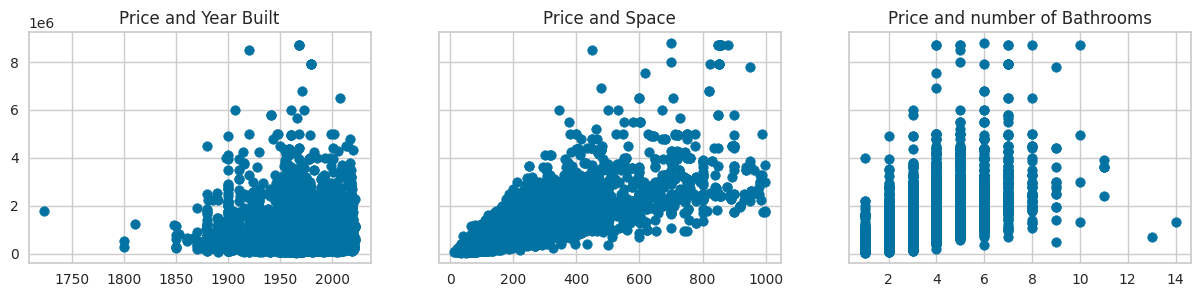

In [36]:
#is built_year a rellevant variable? it has many missing values so it would be interesting to be bale to get rid of it.
#we can compare it to other variables like squared meters and number of bathrooms

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) #sharey -> share 'Price' as y
ax1.scatter(df['built_year'],df['buy_price'])
ax1.set_title('Price and Year Built')
ax2.scatter(df['sq_mt_built'],df['buy_price'])
ax2.set_title('Price and Space')
ax3.scatter(df['n_bathrooms'],df['buy_price'])
ax3.set_title('Price and number of Bathrooms')


plt.show()

In [37]:
#regarding built_year and new_development: if it has a built year, it can't be new development. we'll replenish the values accordingly.
#afterwards we'll be able to get rid of built_year. it has many missing values and as we saw above there's no clear relation of year built and price
cannot_be_new=(df['is_new_development'].isnull()) & (~df['built_year'].isnull())
df['is_new_development'][cannot_be_new]=False
df.drop(columns='built_year',inplace=True)

In [38]:
#now we will fillthe rest of new_development nans with mode
developmod=df['is_new_development'].mode()[0]
df['is_new_development']=df['is_new_development'].fillna(developmod)

In [39]:
#let's see how are nans looking now
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
has_lift,1411,0.082169
is_exterior,1411,0.082169
sq_mt_built,0,0.000000
has_balcony,0,0.000000
house_type_id_HouseType 5: Áticos,0,0.000000
house_type_id_HouseType 4: Dúplex,0,0.000000
house_type_id_HouseType 2: Casa o chalet,0,0.000000
house_type_id_HouseType 1: Pisos,0,0.000000
has_parking,0,0.000000
energy_certificate,0,0.000000


In [40]:
print(f'neighborhood ids: {len(df.neighborhood_id.value_counts())}')
print(f'district ids: {len(df.district_id.value_counts())}')

neighborhood ids: 125
district ids: 20


In [41]:
#as seen above, neighborhood id has a lot of unique values as opposed to district id. let's simplify and only use district ids for our analysis.
#we will one hot encode district id and remove one column for avoiding full interdependence. regarding neighborhood id, we'll delete it.
#we'll put NaN to missing values for has_lift and is_exterior 
df=df.drop(columns=["neighborhood_id"])
df['has_lift']=pd.to_numeric(df['has_lift'],errors='coerce')
df['is_exterior']=pd.to_numeric(df['is_exterior'],errors='coerce')
df=pd.get_dummies(df)
df=df.drop(columns=["district_id_21"])
df

,sq_mt_built,n_rooms,n_bathrooms,buy_price,is_renewal_needed,is_new_development,has_ac,has_fitted_wardrobes,has_lift,is_exterior,...,district_id_19,district_id_2,district_id_20,district_id_3,district_id_4,district_id_5,district_id_6,district_id_7,district_id_8,district_id_9
id,,,,,,,,,,,,,,,,,,,,,
19795,78.0,3,1.0,156000,False,False,False,True,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
360,169.0,3,2.0,620000,False,False,True,True,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
19517,30.0,0,1.0,150000,False,False,False,False,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
16541,74.0,3,1.0,290000,False,False,False,False,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6176,180.0,3,3.0,940000,False,False,True,True,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9778,75.0,1,2.0,350000,True,False,True,False,0.0,1.0,...,0,0,0,0,0,0,1,0,0,0
167,343.0,4,4.0,2800000,False,False,True,True,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
16352,61.0,2,1.0,99000,True,False,False,True,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
#for the sake of simplicity, let's see if we can rename some long columns
df.columns

Index(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'buy_price',
       'is_renewal_needed', 'is_new_development', 'has_ac',
       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden',
       'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room',
       'is_accessible', 'has_green_zones', 'has_parking',
       'house_type_id_HouseType 1: Pisos',
       'house_type_id_HouseType 2: Casa o chalet',
       'house_type_id_HouseType 4: Dúplex',
       'house_type_id_HouseType 5: Áticos', 'energy_certificate_A',
       'energy_certificate_B', 'energy_certificate_C', 'energy_certificate_D',
       'energy_certificate_E', 'energy_certificate_F', 'energy_certificate_G',
       'energy_certificate_en trámite', 'energy_certificate_inmueble exento',
       'energy_certificate_no indicado', 'district_id_1', 'district_id_10',
       'district_id_11', 'district_id_12', 'district_id_13', 'district_id_14',
       'district_id_15', 'district_id_17', 'district_id_18', 'district_id_19',
    

In [43]:
df.rename(columns= {'sq_mt_built':'sq_metres', 'n_rooms':'rooms', 'n_bathrooms':'bathrooms','is_renewal_needed':'needs_renewal', 'is_new_development':'is_new', 'has_fitted_wardrobes':'fitted_wardrobes', 'has_storage_room':'storage_room', 'house_type_id_HouseType 1: Pisos':'HouseType 1: Pisos', 'house_type_id_HouseType 2: Casa o chalet':'HouseType 2: Casa o chalet', 'house_type_id_HouseType 4: Dúplex':'HouseType 4: Dúplex', 'house_type_id_HouseType 5: Áticos':'HouseType 5: Áticos'}, inplace=True)

In [44]:
#before moving further, let's concentrate all the preprocessing we've done in a function so we can apply it to the test and also to future predictions:
def prepare(df):
    df.drop(columns=['rent_price','is_rent_price_known'], inplace=True)
    df.drop(columns=['portal','latitude','has_private_parking','are_pets_allowed','is_kitchen_equipped','longitude','longitude','rent_price_by_area','is_furnished','door'], inplace=True)
    df.drop(columns=['is_buy_price_known'], inplace=True)
    df.drop(columns=['title','street_number','street_name','raw_address','is_exact_address_hidden'], inplace=True)
    df.drop(columns=['operation'], inplace=True)
    df.drop(columns=['has_public_parking'], inplace=True)
    df=df[df['sq_mt_built'].notna()]
    df=df[df['n_bathrooms'].notna()]
    nan_is_false=["has_garden","has_ac","has_fitted_wardrobes", "has_garden", "has_pool", "has_terrace", "has_balcony", "has_storage_room", "is_accessible", "has_green_zones", ]
    for column in nan_is_false:
        df[column]=df[column].fillna(False)
    df.drop(columns=['sq_mt_allotment','sq_mt_useful','parking_price','is_parking_included_in_price','n_floors',], inplace=True)
    df.drop(columns=['is_orientation_east','is_orientation_south','is_orientation_west','is_orientation_north','has_individual_heating','has_central_heating','floor','is_floor_under','buy_price_by_area', 'subtitle'], inplace=True)
    df['house_type_id']=df['house_type_id'].fillna("miscelaneous")
    df=pd.get_dummies(df,columns=['house_type_id'])
    df.drop(columns='house_type_id_miscelaneous', inplace=True)
    es_casa_duda_ascensor=(df['has_lift'].isnull()) & (df['house_type_id_HouseType 2: Casa o chalet']==0)
    df['has_lift'][es_casa_duda_ascensor]=liftmode
    es_casa_duda_exterior=(df['is_exterior'].isnull()) & (df['house_type_id_HouseType 2: Casa o chalet']==0)
    df['is_exterior'][es_casa_duda_exterior]=exteriormode
    df['district_id']=df['neighborhood_id'].copy()
    df.district_id=df.district_id.str.extract(r'(District \d+)')
    df.neighborhood_id=df.neighborhood_id.str.extract(r'(Neighborhood \d+)')
    df.district_id=df.district_id.str.extract(r'(\d+)')
    df.neighborhood_id=df.neighborhood_id.str.extract(r'(\d+)')
    cannot_be_new=(df['is_new_development'].isnull()) & (~df['built_year'].isnull())
    df['is_new_development'][cannot_be_new]=False
    df.drop(columns='built_year',inplace=True)
    df['is_new_development']=df['is_new_development'].fillna(developmod)
    df=df.drop(columns=["neighborhood_id"])
    df['has_lift']=pd.to_numeric(df['has_lift'],errors='coerce')
    df['is_exterior']=pd.to_numeric(df['is_exterior'],errors='coerce')
    df=pd.get_dummies(df)
    df=df.drop(columns=["district_id_21"])
    df.rename(columns= {'sq_mt_built':'sq_metres', 'n_rooms':'rooms', 'n_bathrooms':'bathrooms','is_renewal_needed':'needs_renewal', 'is_new_development':'is_new', 'has_fitted_wardrobes':'fitted_wardrobes', 'has_storage_room':'storage_room', 'house_type_id_HouseType 1: Pisos':'HouseType 1: Pisos', 'house_type_id_HouseType 2: Casa o chalet':'HouseType 2: Casa o chalet', 'house_type_id_HouseType 4: Dúplex':'HouseType 4: Dúplex', 'house_type_id_HouseType 5: Áticos':'HouseType 5: Áticos'}, inplace=True)
    return df


In [45]:
#let's apply the preprocessing to the test set
testing=prepare(test_set)
testing

/tmp/ipykernel_32548/1286149880.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['has_lift'][es_casa_duda_ascensor]=liftmode
/tmp/ipykernel_32548/1286149880.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_exterior'][es_casa_duda_exterior]=exteriormode
/tmp/ipykernel_32548/1286149880.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_new_development'][cannot_be_new]=False


,sq_metres,rooms,bathrooms,buy_price,needs_renewal,is_new,has_ac,fitted_wardrobes,has_lift,is_exterior,...,district_id_19,district_id_2,district_id_20,district_id_3,district_id_4,district_id_5,district_id_6,district_id_7,district_id_8,district_id_9
id,,,,,,,,,,,,,,,,,,,,,
485,82.0,3,2.0,241813,False,True,False,True,1.0,1.0,...,1,0,0,0,0,0,0,0,0,0
18512,130.0,3,2.0,950000,False,False,True,True,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2952,66.0,4,1.0,230000,True,False,False,False,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
14367,840.0,6,5.0,3500000,False,False,True,True,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
9375,71.0,1,1.0,585000,False,True,True,True,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21257,60.0,2,1.0,70000,False,False,False,True,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6554,250.0,4,3.0,1395000,False,False,True,True,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
20775,125.0,3,2.0,402900,False,True,False,True,1.0,1.0,...,1,0,0,0,0,0,0,0,0,0


In [46]:
#now that the data is clean, let's analyse it a little bit:

display(df.dtypes)
display(df.info())
display(df.describe(include='all'))

sq_metres                             float64
rooms                                   int64
bathrooms                             float64
buy_price                               int64
needs_renewal                            bool
is_new                                   bool
has_ac                                   bool
fitted_wardrobes                         bool
has_lift                              float64
is_exterior                           float64
has_garden                               bool
has_pool                                 bool
has_terrace                              bool
has_balcony                              bool
storage_room                             bool
is_accessible                            bool
has_green_zones                          bool
has_parking                              bool
HouseType 1: Pisos                      uint8
HouseType 2: Casa o chalet              uint8
HouseType 4: Dúplex                     uint8
HouseType 5: Áticos               

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17172 entries, 19795 to 5947
Data columns (total 51 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   sq_metres                           17172 non-null  float64
 1   rooms                               17172 non-null  int64  
 2   bathrooms                           17172 non-null  float64
 3   buy_price                           17172 non-null  int64  
 4   needs_renewal                       17172 non-null  bool   
 5   is_new                              17172 non-null  bool   
 6   has_ac                              17172 non-null  bool   
 7   fitted_wardrobes                    17172 non-null  bool   
 8   has_lift                            15761 non-null  float64
 9   is_exterior                         15761 non-null  float64
 10  has_garden                          17172 non-null  bool   
 11  has_pool                            17

None

,sq_metres,rooms,bathrooms,buy_price,needs_renewal,is_new,has_ac,fitted_wardrobes,has_lift,is_exterior,...,district_id_19,district_id_2,district_id_20,district_id_3,district_id_4,district_id_5,district_id_6,district_id_7,district_id_8,district_id_9
count,17172.000000,17172.000000,17172.000000,1.717200e+04,17172,17172,17172,17172,15761.000000,15761.000000,...,17172.000000,17172.000000,17172.000000,17172.000000,17172.000000,17172.000000,17172.000000,17172.000000,17172.000000,17172.000000
unique,NaN,NaN,NaN,NaN,2,2,2,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,False,False,True,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,14036,15997,8837,10608,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,146.074656,2.977929,2.052644,6.354137e+05,NaN,NaN,NaN,NaN,0.774570,0.910729,...,0.024750,0.001514,0.028244,0.070231,0.081936,0.085954,0.080130,0.063534,0.056254,0.066387
std,132.646694,1.462171,1.326374,7.515380e+05,NaN,NaN,NaN,NaN,0.417878,0.285144,...,0.155366,0.038883,0.165673,0.255543,0.274275,0.280304,0.271503,0.243927,0.230419,0.248965
min,13.000000,0.000000,1.000000,3.600000e+04,NaN,NaN,NaN,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.000000,2.000000,1.000000,1.960000e+05,NaN,NaN,NaN,NaN,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,3.000000,2.000000,3.700000e+05,NaN,NaN,NaN,NaN,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,160.000000,4.000000,2.000000,7.500000e+05,NaN,NaN,NaN,NaN,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
#we can observe the following:
#-21421 apartments
#-data types are correct
#-the only columns with NaN are because these NaNs refer to attributes that are only regarding appartments and not houses

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

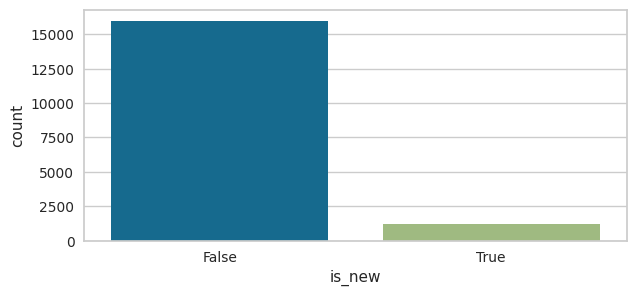

In [48]:
#let's see the quantity of listings which are newly developed vs those which are olden
plt.figure(figsize=(7,3))
sns.countplot(x='is_new', data=df);

In [49]:
#Most of the properties listed are old listings

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

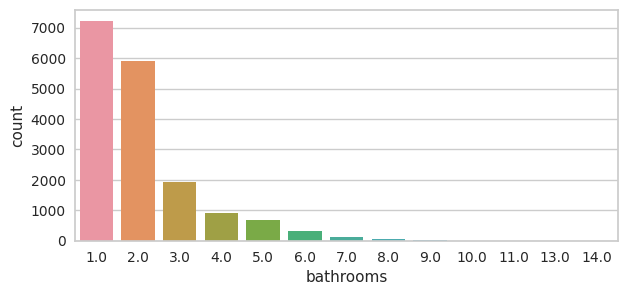

In [50]:
#let's see the frequency of bathrooms
plt.figure(figsize=(7,3))
sns.countplot(x='bathrooms', data=df);

In [51]:
#the most common numer of bathrooms is one or two

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


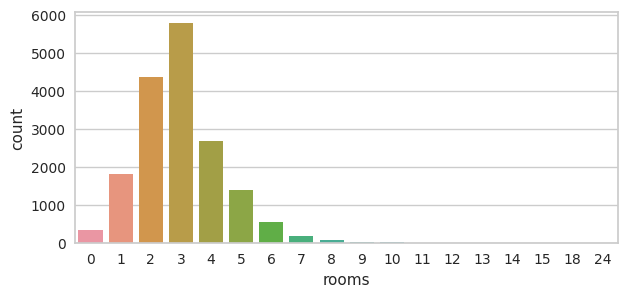

In [52]:
#let's see frequency of rooms
plt.figure(figsize=(7,3))
sns.countplot(x='rooms', data=df);

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

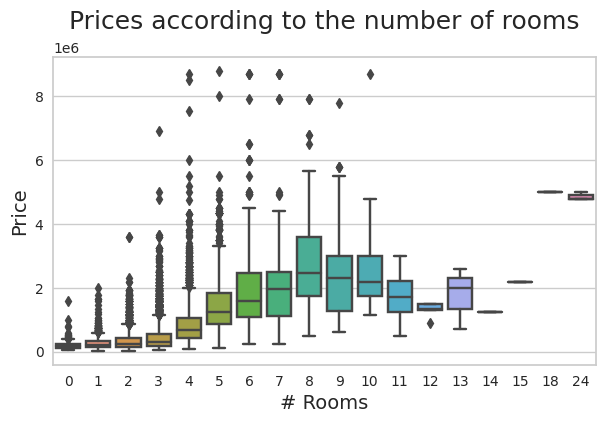

In [53]:
#let's see if number of rooms affects the price or not
sns.boxplot(data=df, x='rooms', y='buy_price')
plt.title('Prices according to the number of rooms', fontsize=18, pad=20)
plt.xlabel('# Rooms', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.gcf().set_size_inches(7, 4)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

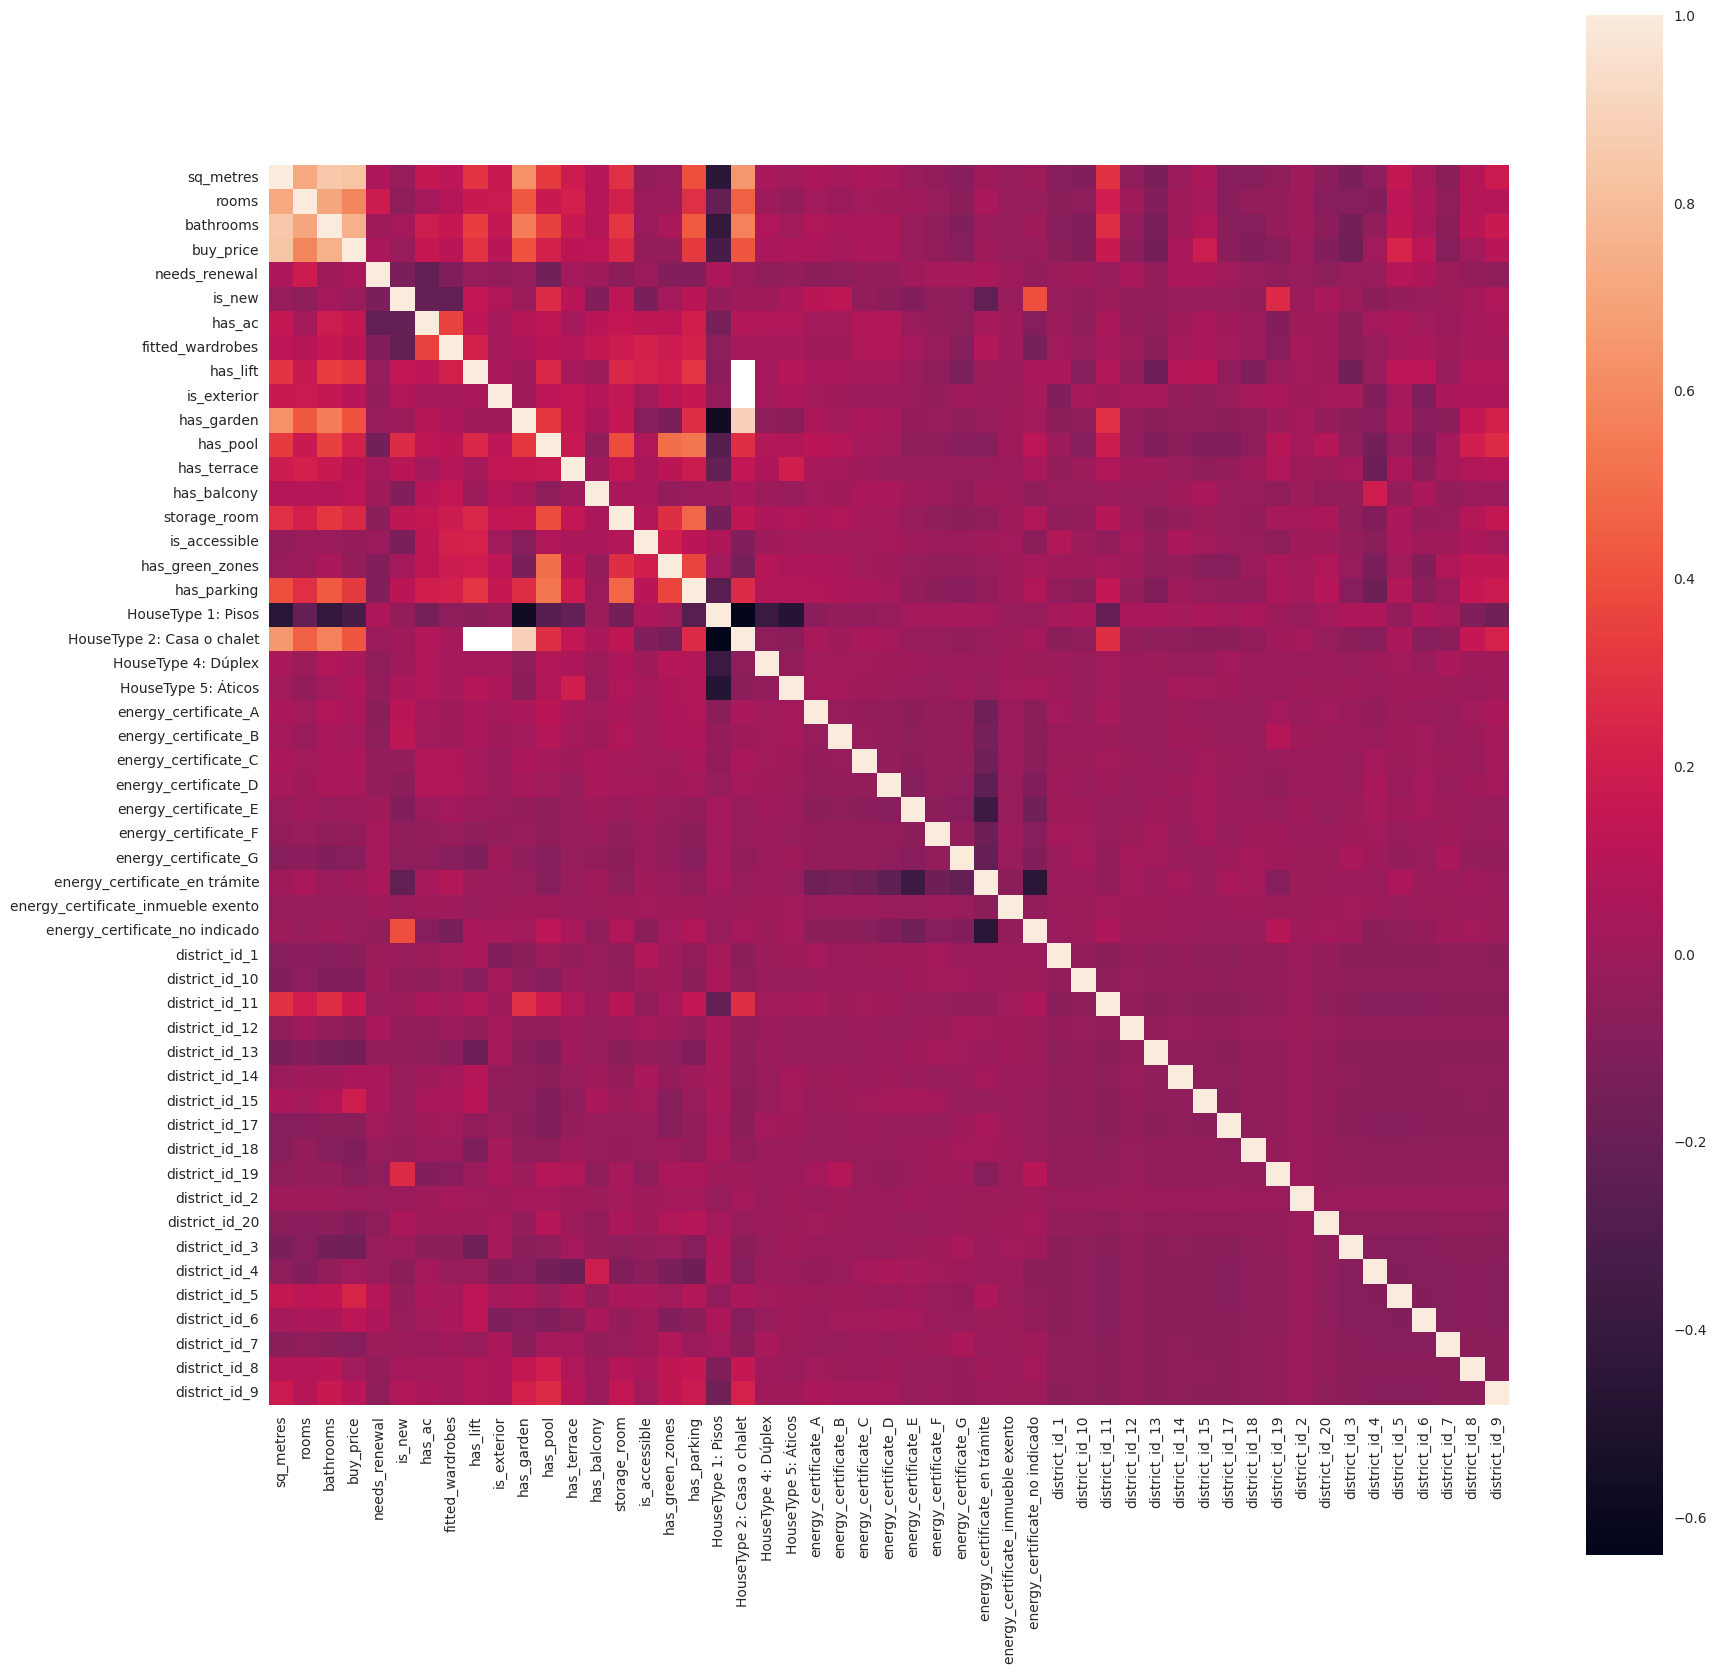

In [54]:
#let's check again the correlation matrix:
corremat = df.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corremat, square=True);

In [55]:
#listing the variables that have a high correlation to our target will help us understand better:
corremat['buy_price'].sort_values(ascending=False)

buy_price                             1.000000
sq_metres                             0.832043
bathrooms                             0.755595
rooms                                 0.586861
HouseType 2: Casa o chalet            0.419426
has_garden                            0.404789
has_parking                           0.323202
has_lift                              0.301086
storage_room                          0.254850
district_id_5                         0.235072
has_pool                              0.215320
district_id_15                        0.187111
district_id_11                        0.169267
has_ac                                0.160389
district_id_6                         0.119377
has_balcony                           0.117074
fitted_wardrobes                      0.111667
has_terrace                           0.110838
district_id_9                         0.107933
is_exterior                           0.105218
HouseType 5: Áticos                   0.062848
energy_certif

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


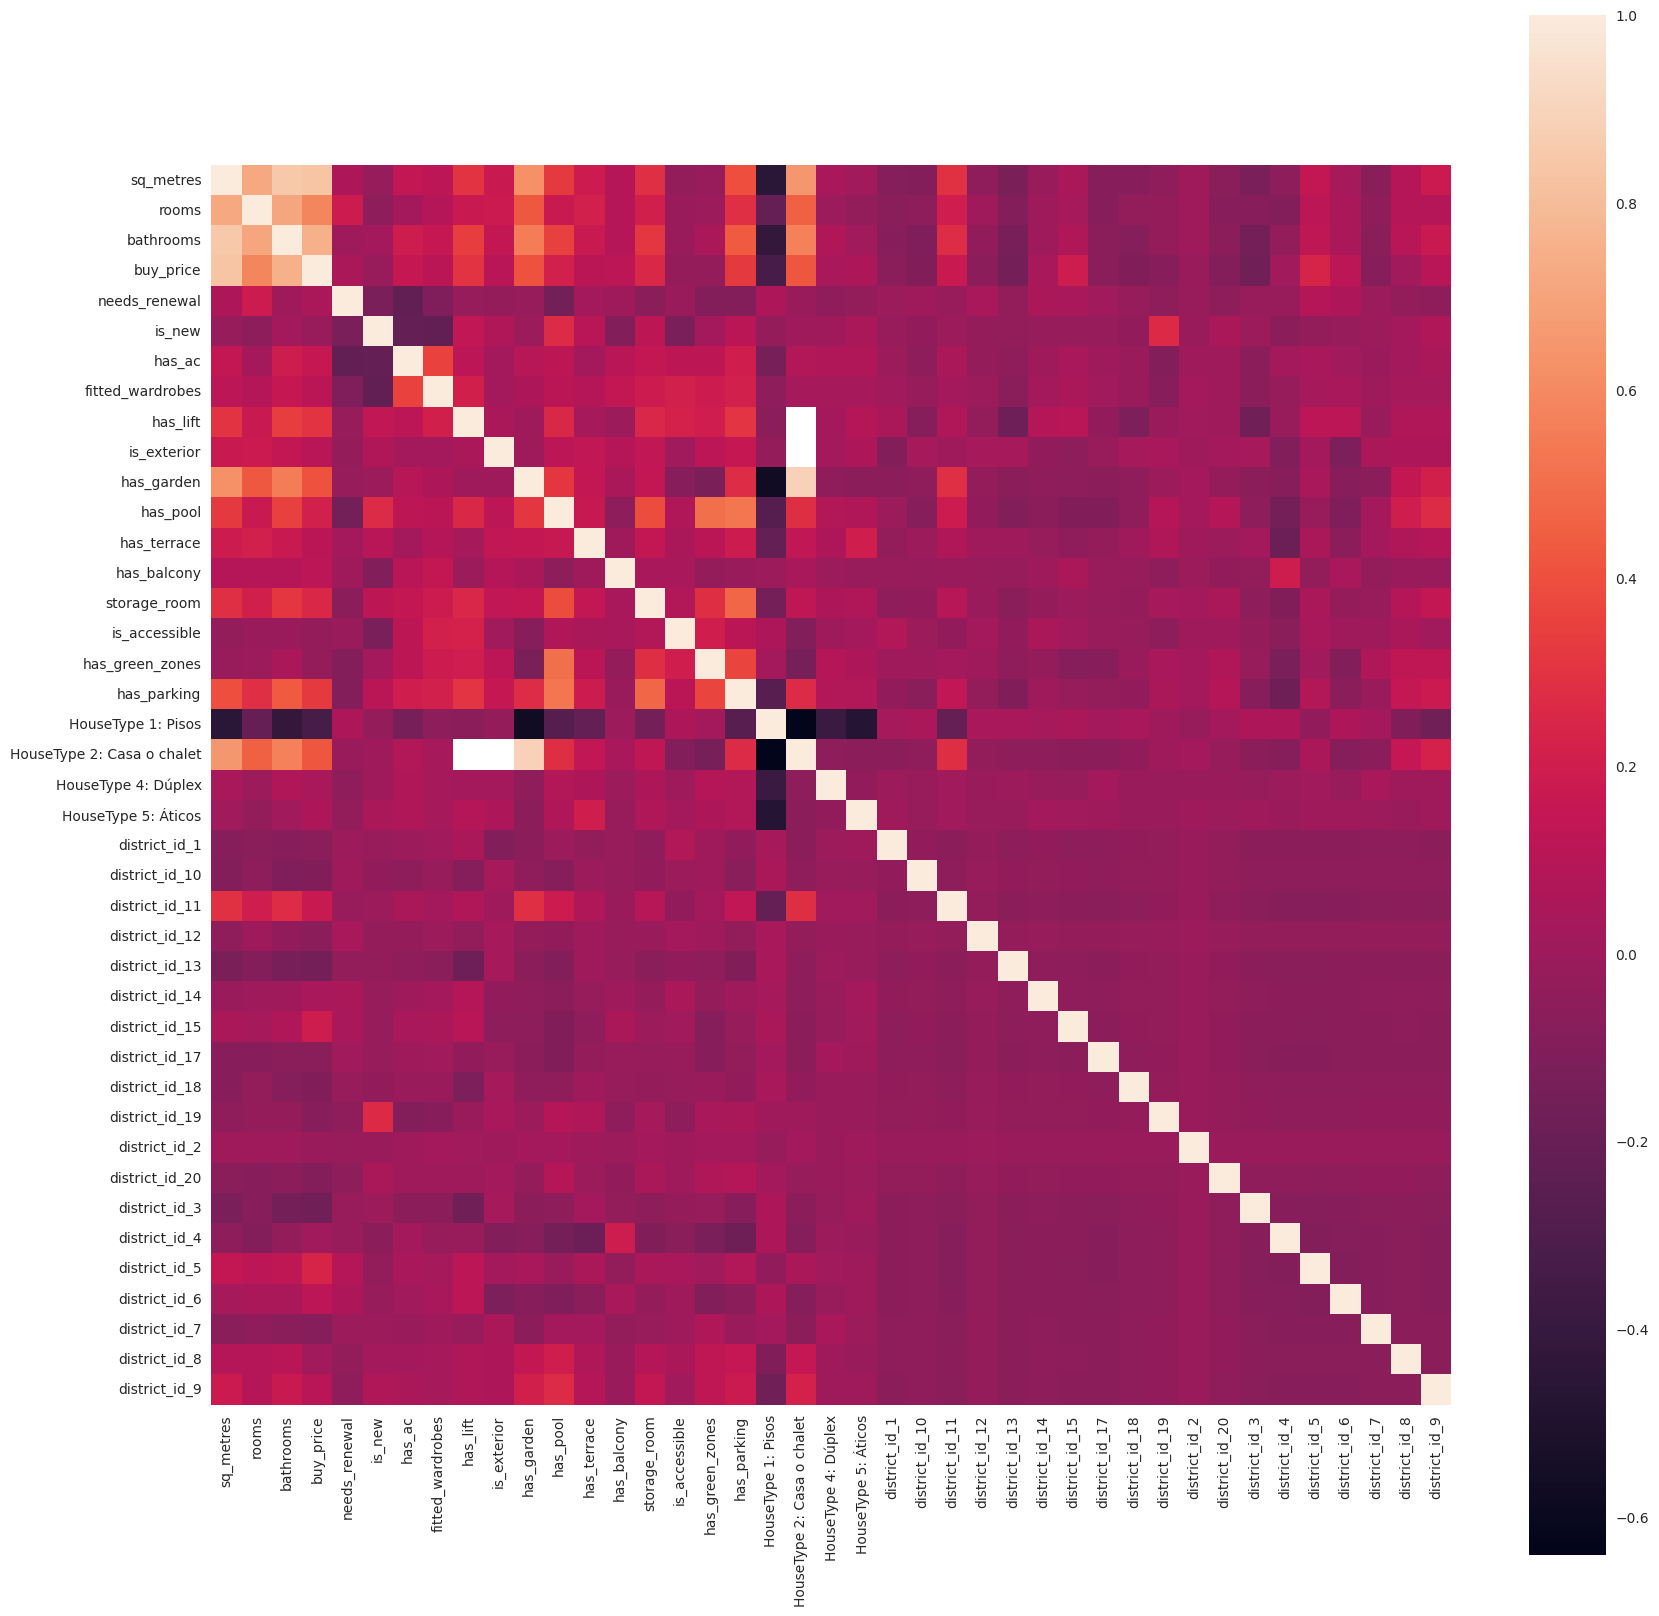

In [56]:
#the energy certificate columns have very little correlation to the target and add a lot of variables, so let's remove them for the sake of simplification:
df=df.drop(columns=["energy_certificate_A",'energy_certificate_B','energy_certificate_C','energy_certificate_D','energy_certificate_E','energy_certificate_F','energy_certificate_G','energy_certificate_en trámite','energy_certificate_inmueble exento','energy_certificate_no indicado'])
corremat = df.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corremat, square=True);

In [57]:
#has_garden is very highly correlated to house_type casa, so we'll get rid of it in order to avoid colinearility:
cols=['HouseType 1: Pisos','HouseType 2: Casa o chalet','HouseType 4: Dúplex','HouseType 5: Áticos']
df[cols][df['has_garden']==True].value_counts()

HouseType 1: Pisos  HouseType 2: Casa o chalet  HouseType 4: Dúplex  HouseType 5: Áticos
0                   1                           0                    0                      1127
                    0                           0                    0                         1
dtype: int64

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

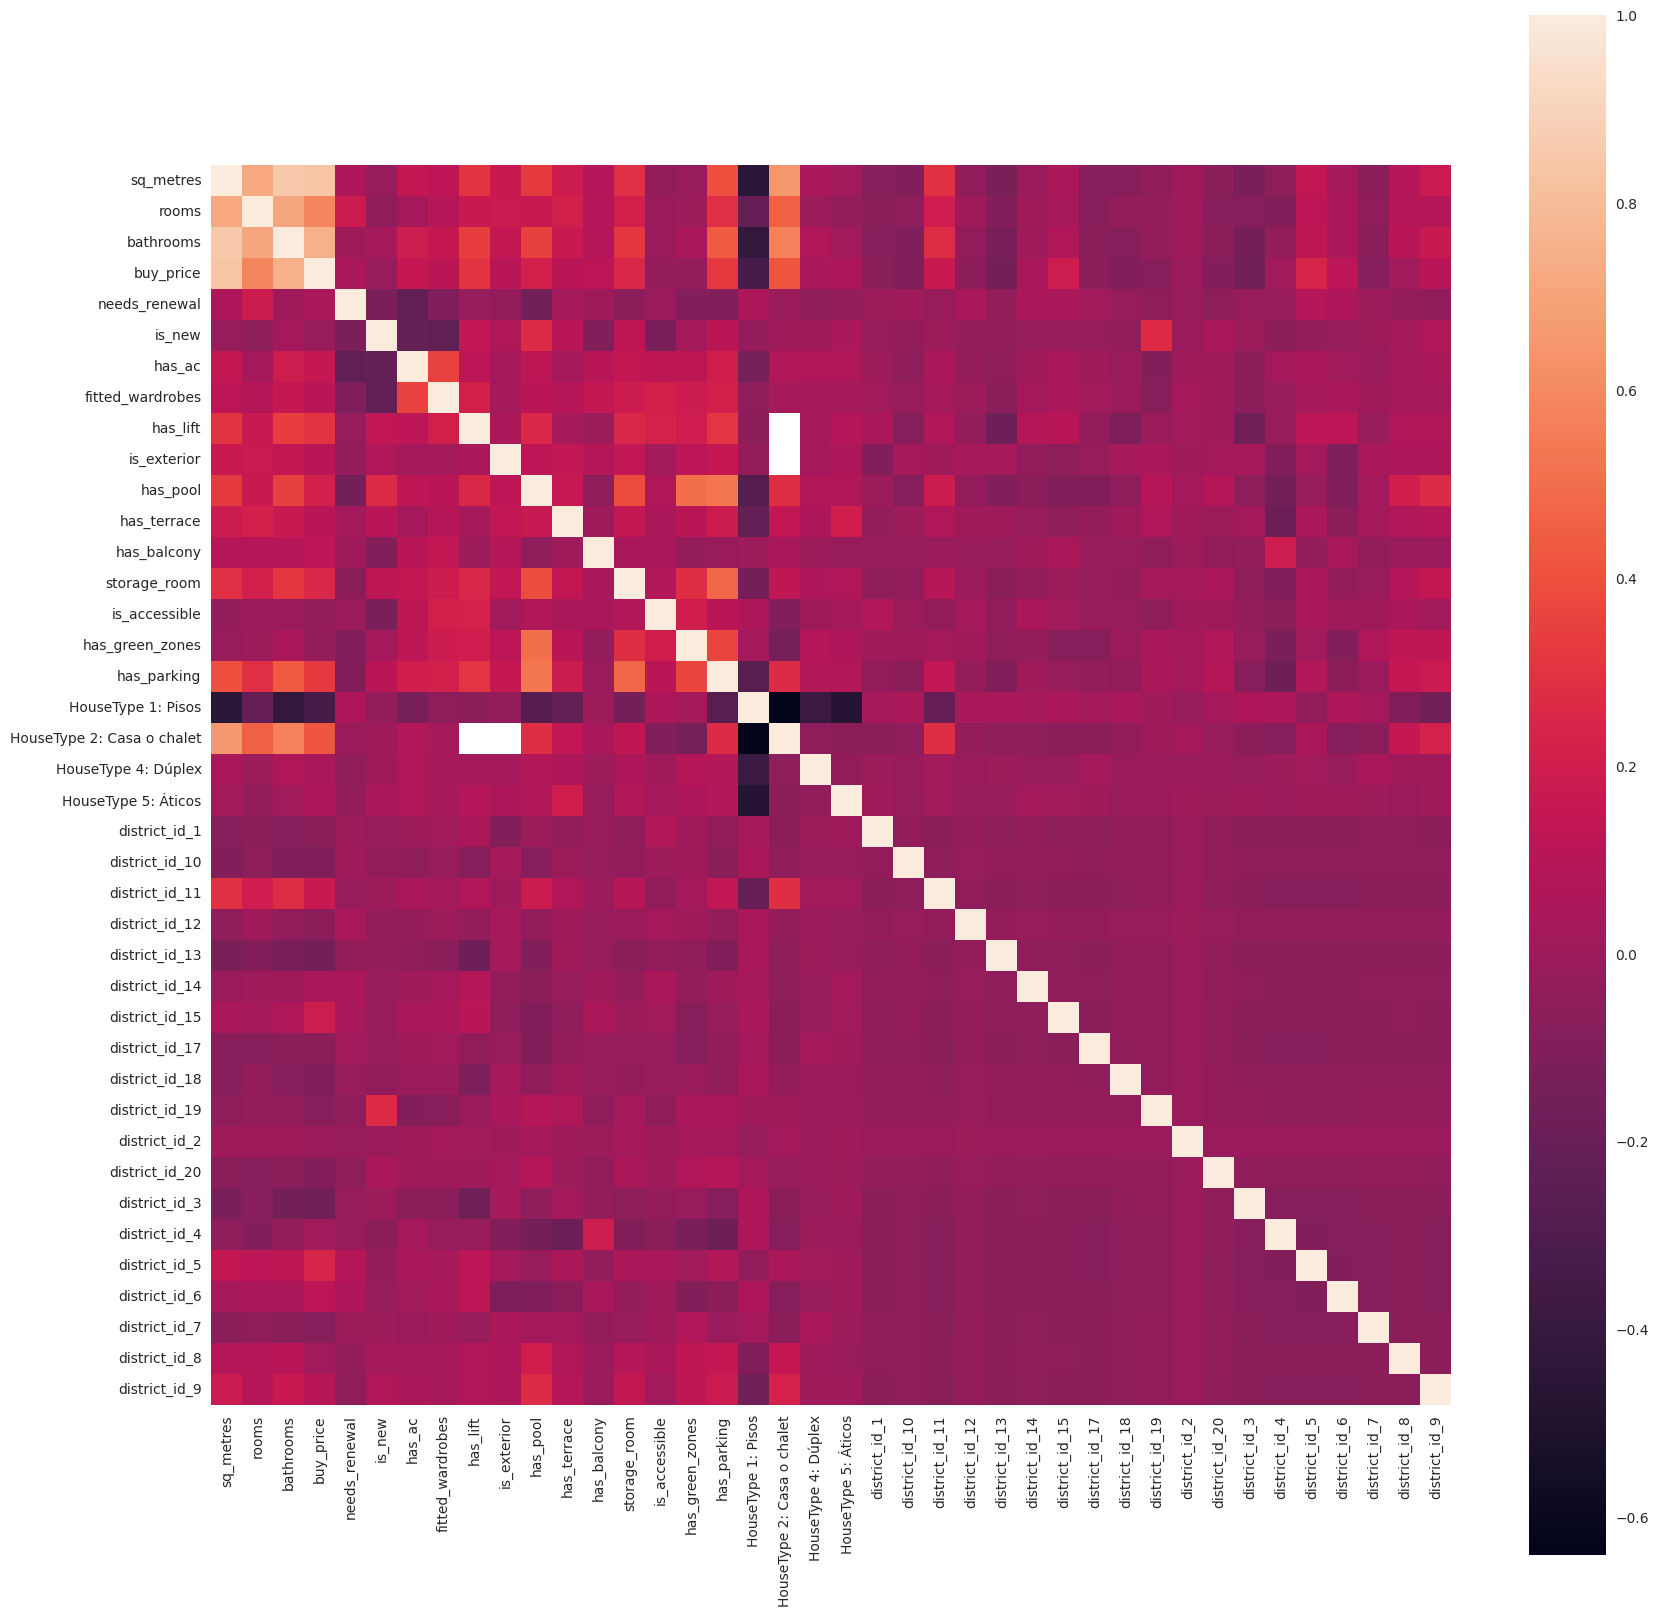

In [58]:
df=df.drop(columns=['has_garden'])
corremat = df.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corremat, square=True);

In [59]:
#before moving further we need to prepare our our train/test targets:
train_y=df[['buy_price']]
train_X=df.drop(columns='buy_price')
test_y=testing[['buy_price']]
test_X=testing.drop(columns='buy_price')

In [60]:
#we still have some missing values. we'll get rid of their columns for smooth training:
train_X_nonna=train_X.drop(columns=['has_lift','is_exterior'])
test_X_nonna=test_X.drop(columns=['has_lift','is_exterior'])

In [61]:
#let's standarize the numerical features

numericals=['sq_metres','rooms','bathrooms']
st_scaler=preprocessing.StandardScaler()
train_X_std=train_X_nonna.copy()
test_X_std=test_X_nonna.copy()
for column in numericals:
    train_X_std[column]=st_scaler.fit_transform(train_X_std[[column]])
    test_X_std[column]=st_scaler.transform(test_X_std[[column]])

In [62]:
#it's time to try some models! we'll use K-fold so we don't need to train until we've found the best model. we'll evaluate on:
#-R2
#-MAE
#-RMSE
scores=['r2','neg_mean_absolute_error','neg_mean_squared_error']

In [63]:
#First batch of K-Folds are the ones that work best with standarized input. In particular:
#-Dummy Regressor which will give us the Mean as Baseline
#-Linear Regression
#-K-Neighbors Regressor
#-SVR (a model that calculates the errors based on a threshold of values rather than squared error)

for model in [DummyRegressor, LinearRegression,KNeighborsRegressor,SVR]:
    if model==SVR:
        cls=model(kernel='linear')
    else:
        cls=model()
    kfold=model_selection.KFold(n_splits=10)
    results=model_selection.cross_validate(cls,train_X_std,train_y,scoring=scores,cv=kfold)
    print(
        f"{model.__name__:22} Fit Time: "
        f"{results['fit_time'].mean():.3f}s  R2: "
        f"{results['test_r2'].mean():.3f}  MAE: "
        f"{results['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
        f"{math.sqrt(results['test_neg_mean_squared_error'].mean()*-1):.3f}"
    )

DummyRegressor         Fit Time: 0.003s  R2: -0.000  MAE: 484134.700  RMSE: 751539.137
LinearRegression       Fit Time: 0.049s  R2: 0.780  MAE: 187021.455  RMSE: 352835.708
KNeighborsRegressor    Fit Time: 0.010s  R2: 0.828  MAE: 144989.113  RMSE: 311799.487


/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-

SVR                    Fit Time: 7.200s  R2: -0.067  MAE: 412409.630  RMSE: 776292.585


In [64]:
#for the moment KNeighborsRegressor  seems a good option!
#Let's keep checking models, tho.
#Now it's the turn of models that, although work well with no need to standarize, cannot miss any values. These are:
#-Decision Tree Regressor
#-Random Forest Regressor

for model in [DecisionTreeRegressor, RandomForestRegressor]:
    cls=model()
    kfold=model_selection.KFold(n_splits=10)
    results=model_selection.cross_validate(cls,train_X_nonna,train_y,scoring=scores,cv=kfold)
    mse=results['test_neg_mean_squared_error'].mean()*-1
    rmse=math.sqrt(mse)
    print(
        f"{model.__name__:22} Fit Time: "
        f"{results['fit_time'].mean():.3f}s  R2: "
        f"{results['test_r2'].mean():.3f}  MAE: "
        f"{results['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
        f"{rmse:.3f}"
    )

DecisionTreeRegressor  Fit Time: 0.056s  R2: 0.788  MAE: 144752.030  RMSE: 343957.487


/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/hom

RandomForestRegressor  Fit Time: 3.509s  R2: 0.882  MAE: 115709.220  RMSE: 257252.996


In [65]:
#Random Forest Regressor is the best one for the moment!
#But can still try another model: one that doesn't need data to be standarized and that also doesn't care that there are missing values.
#And that's the XGBRegressor, that stands for "Extreme Gradient Boosting"

for model in [xgb.XGBRegressor]:
    cls=model()
    kfold=model_selection.KFold(n_splits=10)
    results=model_selection.cross_validate(cls,train_X,train_y,scoring=scores,cv=kfold)
    mse=results['test_neg_mean_squared_error'].mean()*-1
    rmse=math.sqrt(mse)
    print(
        f"{model.__name__:22} Fit Time: "
        f"{results['fit_time'].mean():.3f}s  R2: "
        f"{results['test_r2'].mean():.3f}  MAE: "
        f"{results['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
        f"{rmse:.3f}"
    )

XGBRegressor           Fit Time: 0.559s  R2: 0.885  MAE: 118309.028  RMSE: 253712.649


In [66]:
#By little, the XGBRegressor is the one with the best R2 (although it takes more time)
#By order, the models have performed:
#1-XGBRegressor
#2-RandomForestRegressor
#3-KNeighborsRegressor
#4-DecisionTreeRegressor
#5-LinearRegression
#In hindsight, maybe the DummyRegressor was too much of a dummy to be the baseline. 
#Also, the SVR didn't perform well at all, maybe it would have needed more tunning.

In [67]:
#let's not forget we have a lot of columns!
print(f'columns: {len(train_X_std.columns)}') 

columns: 37


/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the foll

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

Index(['sq_metres', 'rooms', 'bathrooms', 'needs_renewal', 'is_new', 'has_ac',
       'fitted_wardrobes', 'has_pool', 'has_terrace', 'has_balcony',
       'storage_room', 'is_accessible', 'has_green_zones', 'has_parking',
       'HouseType 1: Pisos', 'HouseType 2: Casa o chalet',
       'HouseType 4: Dúplex', 'HouseType 5: Áticos', 'district_id_1',
       'district_id_10', 'district_id_11', 'district_id_12', 'district_id_13',
       'district_id_14', 'district_id_15', 'district_id_17', 'district_id_18',
       'district_id_19', 'district_id_2', 'district_id_20', 'district_id_3',
       'district_id_4', 'district_id_5', 'district_id_6', 'district_id_7',
       'district_id_8', 'district_id_9'],
      dtype='object')
[1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
35
[ True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  

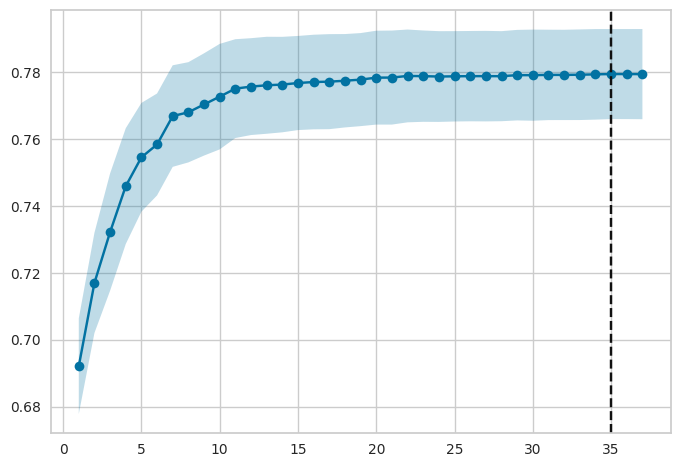

In [68]:
#let's see if all of them are rellevant or if we can get rid of some of them
rfe=RFECV(LinearRegression(),cv=5)
rfe.fit(train_X_std,train_y)
print(train_X_std.columns)
print(rfe.rfe_estimator_.ranking_)
print(rfe.rfe_estimator_.n_features_)
print(rfe.rfe_estimator_.support_)

In [69]:
#so columns with index 12 and 16 are not important and we could get rid of them. These are:
print(f'column index 12: {train_X_std.columns[12]}')
print(f'column index 16: {train_X_std.columns[16]}')

column index 12: has_green_zones
column index 16: HouseType 4: Dúplex


/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the foll

Index(['sq_metres', 'rooms', 'bathrooms', 'needs_renewal', 'is_new', 'has_ac',
       'fitted_wardrobes', 'has_pool', 'has_terrace', 'has_balcony',
       'storage_room', 'is_accessible', 'has_parking', 'HouseType 1: Pisos',
       'HouseType 2: Casa o chalet', 'HouseType 5: Áticos', 'district_id_1',
       'district_id_10', 'district_id_11', 'district_id_12', 'district_id_13',
       'district_id_14', 'district_id_15', 'district_id_17', 'district_id_18',
       'district_id_19', 'district_id_2', 'district_id_20', 'district_id_3',
       'district_id_4', 'district_id_5', 'district_id_6', 'district_id_7',
       'district_id_8', 'district_id_9'],
      dtype='object')
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
35
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

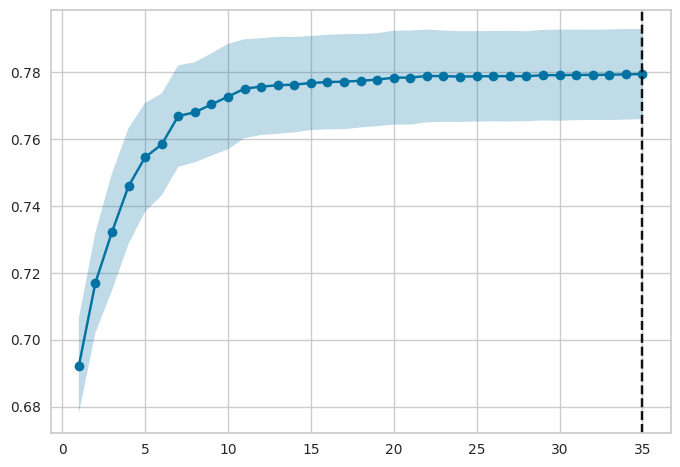

In [70]:
#let's double check by removing them:
train_X_std_clean = train_X_std.drop(columns=["has_green_zones","HouseType 4: Dúplex"])
rfe2=RFECV(LinearRegression(),cv=5)
rfe2.fit(train_X_std_clean,train_y)
print(train_X_std_clean.columns)
print(rfe2.rfe_estimator_.ranking_)
print(rfe2.rfe_estimator_.n_features_)
print(rfe2.rfe_estimator_.support_)

In [71]:
#I need to see with my own eyes that removing these features really doesn't affect the outcome. So, let's do some other k-folds:

#KNeighbors and LinearRegression required standarization and not having missing values:

for model in [LinearRegression,KNeighborsRegressor]:
    cls=KNeighborsRegressor()
    kfold=model_selection.KFold(n_splits=10)
    results=model_selection.cross_validate(cls,train_X_std_clean,train_y,scoring=scores,cv=kfold)
    print(
        f"{model.__name__:22}  Fit Time: "
        f"{results['fit_time'].mean():.3f}s  R2: "
        f"{results['test_r2'].mean():.3f}  MAE: "
        f"{results['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
        f"{math.sqrt(results['test_neg_mean_squared_error'].mean()*-1):.3f}"
        )
    
#RandomForest and DecisionTreeRegressor didn't require standarization but it was compulsory for them not to have NaNs:

train_X_nonna_clean = train_X_nonna.drop(columns=["has_green_zones","HouseType 4: Dúplex"])

for model in [DecisionTreeRegressor, RandomForestRegressor]:
    cls=model()
    kfold=model_selection.KFold(n_splits=10)
    results=model_selection.cross_validate(cls,train_X_nonna_clean,train_y,scoring=scores,cv=kfold)
    mse=results['test_neg_mean_squared_error'].mean()*-1
    rmse=math.sqrt(mse)
    print(
        f"{model.__name__:22} Fit Time: "
        f"{results['fit_time'].mean():.3f}s  R2: "
        f"{results['test_r2'].mean():.3f}  MAE: "
        f"{results['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
        f"{rmse:.3f}"
    )
    
#XGBRegressor doesn't need removing NaNs or stasndarizing:

train_X_clean = train_X.drop(columns=["has_green_zones","HouseType 4: Dúplex"])
    
for model in [xgb.XGBRegressor]:
    cls=model()
    kfold=model_selection.KFold(n_splits=10)
    results=model_selection.cross_validate(cls,train_X_clean,train_y,scoring=scores,cv=kfold)
    mse=results['test_neg_mean_squared_error'].mean()*-1
    rmse=math.sqrt(mse)
    print(
        f"{model.__name__:22} Fit Time: "
        f"{results['fit_time'].mean():.3f}s  R2: "
        f"{results['test_r2'].mean():.3f}  MAE: "
        f"{results['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
        f"{rmse:.3f}"
    )

LinearRegression        Fit Time: 0.008s  R2: 0.826  MAE: 144754.575  RMSE: 312981.462
KNeighborsRegressor     Fit Time: 0.008s  R2: 0.826  MAE: 144754.575  RMSE: 312981.462
DecisionTreeRegressor  Fit Time: 0.061s  R2: 0.794  MAE: 142417.063  RMSE: 338247.158


/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/hom

RandomForestRegressor  Fit Time: 3.579s  R2: 0.884  MAE: 115172.303  RMSE: 255571.312
XGBRegressor           Fit Time: 0.559s  R2: 0.887  MAE: 117834.660  RMSE: 251771.631


In [72]:
#linear regression improves as expected, kneighbors stays almost the same (goes down 0.002 points), DecisionTreeRegressor goes down 0.007 points, RandomForestRegressor stays exactly the same and XGBRegressor goes up 0.002 pounts! 
#so, for each model, we'll use:
#-XGBRegressor: train_X_clean (R2: 0.887)
#-kneighbors: train_X_std (R2: 0.828)
#-linear regression: train_X_std_clean (R2: 0.826)
#-randomforestregressor: train_X_nonna_clean (R2: 0.793)
#-decisiontreeregressor: train_X_nonna (R2: 0.793)

In [74]:
#moving on, time to tune our models! we'll need to do a GridSearch for that.
#let's start with XGBRegressor:

paramsXGB = {
    'max_depth': [10,100,1000],
    'n_estimators': [10,100,1000],
}

xgridXGB = GridSearchCV(estimator=xgb.XGBRegressor(),           
                      param_grid=paramsXGB, 
                      cv=5,
                      verbose=0) 

xgridXGB.fit(train_X_clean, train_y)

print(xgridXGB.best_score_)
print(xgridXGB.best_estimator_)
print(xgridXGB.best_params_)

0.8781028995222051
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
{'max_depth': 10, 'n_estimators': 100}


In [75]:
print(list(zip(xgridXGB.cv_results_['params'],xgridXGB.cv_results_['mean_test_score'])))

[({'max_depth': 10, 'n_estimators': 10}, 0.8767816586176718), ({'max_depth': 10, 'n_estimators': 100}, 0.8781028995222051), ({'max_depth': 10, 'n_estimators': 1000}, 0.8744552283567183), ({'max_depth': 100, 'n_estimators': 10}, 0.8686791347579174), ({'max_depth': 100, 'n_estimators': 100}, 0.8681591505827727), ({'max_depth': 100, 'n_estimators': 1000}, 0.8681598028881625), ({'max_depth': 1000, 'n_estimators': 10}, 0.8686791347579174), ({'max_depth': 1000, 'n_estimators': 100}, 0.8681591505827727), ({'max_depth': 1000, 'n_estimators': 1000}, 0.8681598028881625)]


In [76]:
#let's rerun the grid approximating it a bit more this time:
paramsXGB2 = {
    'max_depth': [5,10,30,50],
    'n_estimators': [50,100,300,500],
}

xgridXGB2 = GridSearchCV(estimator=xgb.XGBRegressor(),           
                      param_grid=paramsXGB2, 
                      cv=5,
                      verbose=0) 

xgridXGB2.fit(train_X_clean, train_y)

print(xgridXGB2.best_score_)
print(xgridXGB2.best_estimator_)
print(xgridXGB2.best_params_)

0.8850249789676164
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
{'max_depth': 5, 'n_estimators': 100}


In [77]:
#and yet another round:
paramsXGB3 = {
    'max_depth': [3,5,7],
    'n_estimators': [70,100,150,200],
}

xgridXGB3 = GridSearchCV(estimator=xgb.XGBRegressor(),           
                      param_grid=paramsXGB3, 
                      cv=5,
                      verbose=0) 

xgridXGB3.fit(train_X_clean, train_y)

print(xgridXGB3.best_score_)
print(xgridXGB3.best_estimator_)
print(xgridXGB3.best_params_)

0.8850249789676164
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
{'max_depth': 5, 'n_estimators': 100}


In [78]:
#ok, we have found out the best parameters for XGBRegressor! 'max_depth': 5, 'n_estimators': 100 at an R2 of 0.885
#let's move on to KNeighborsRegressor

paramskn = [{
        'n_neighbors': [5,10,50,100,1000],
    }]

kgridkn = GridSearchCV(estimator=KNeighborsRegressor(),           
                      param_grid=paramskn, 
                      cv=5,
                      verbose=0) 

kgridkn.fit(train_X_std, train_y)

print(kgridkn.best_score_)
print(kgridkn.best_estimator_)
print(kgridkn.best_params_)
print(list(zip(kgridkn.cv_results_['params'],kgridkn.cv_results_['mean_test_score'])))

0.8214893293398751
KNeighborsRegressor()
{'n_neighbors': 5}
[({'n_neighbors': 5}, 0.8214893293398751), ({'n_neighbors': 10}, 0.8202259033435352), ({'n_neighbors': 50}, 0.7856981626134809), ({'n_neighbors': 100}, 0.7652477351260268), ({'n_neighbors': 1000}, 0.652185349956815)]


In [79]:
#we'll need another round to get a bit closer:

paramskn2 = [{
        'n_neighbors': [3,5,7,9,11],
    }]

kgridkn2 = GridSearchCV(estimator=KNeighborsRegressor(),           
                      param_grid=paramskn2, 
                      cv=5,
                      verbose=0) 

kgridkn2.fit(train_X_std, train_y)

print(kgridkn2.best_score_)
print(kgridkn2.best_estimator_)
print(kgridkn2.best_params_)

0.8221336362629206
KNeighborsRegressor(n_neighbors=7)
{'n_neighbors': 7}


In [80]:
#we got a winner! 'n_neighbors': 7 at a R2 of 0.822
#regarding LinearRegression, there's not parameters to tune in a grid search.If most models are above the R2 of 0.826 that the LinearRegression got in the kfold, this model won't be needed anymore.
#time for tunning the RandomForestRegressor!

paramsrandom = [{
    'n_estimators': [10,100,500,1000,2000]
    }]

fgridrandom = GridSearchCV(estimator=RandomForestRegressor(),           
                      param_grid=paramsrandom, 
                      cv=5,
                      verbose=0) 

fgridrandom.fit(train_X_nonna_clean, train_y)
print(fgridrandom.best_score_)
print(fgridrandom.best_estimator_)
print(fgridrandom.best_params_)
print(list(zip(fgridrandom.cv_results_['params'],fgridrandom.cv_results_['mean_test_score'])))

/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/hom

/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.8848866113513859
RandomForestRegressor(n_estimators=1000)
{'n_estimators': 1000}
[({'n_estimators': 10}, 0.8716171205003841), ({'n_estimators': 100}, 0.8833701920190545), ({'n_estimators': 500}, 0.8844271726716821), ({'n_estimators': 1000}, 0.8848866113513859), ({'n_estimators': 2000}, 0.8848693652521069)]


In [81]:
#so according to this we can get a whooping R2 of 0.885 if we have 1000 n_estimators.
#let's try tune it a little bit more:

paramsrandom2 = [{
    'n_estimators': [700,1000,1200,1500]
    }]

fgridrandom2 = GridSearchCV(estimator=RandomForestRegressor(),           
                      param_grid=paramsrandom2, 
                      cv=5,
                      verbose=0) 

fgridrandom2.fit(train_X_nonna_clean, train_y)
print(fgridrandom2.best_score_)
print(fgridrandom2.best_estimator_)
print(fgridrandom2.best_params_)
print(list(zip(fgridrandom2.cv_results_['params'],fgridrandom2.cv_results_['mean_test_score'])))

/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/hom

0.8852670849005408
RandomForestRegressor(n_estimators=1200)
{'n_estimators': 1200}
[({'n_estimators': 700}, 0.8852599359555781), ({'n_estimators': 1000}, 0.8846158344701086), ({'n_estimators': 1200}, 0.8852670849005408), ({'n_estimators': 1500}, 0.8846820519462757)]


In [82]:
#so its settled, for RandomForestRegressor the optimal number of estimators is 1000, at a R2 of 0.885
#now it is time to do a grid search on a DecisionTreeRegressor:

paramsdecision = [{
    "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100]
    }]

fgriddecision = GridSearchCV(estimator=DecisionTreeRegressor(),           
                      param_grid=paramsdecision, 
                      cv=5,
                      verbose=0) 

fgriddecision.fit(train_X_nonna, train_y)
print(fgriddecision.best_score_)
print(fgriddecision.best_estimator_)
print(fgriddecision.best_params_)

0.8166683116744329
DecisionTreeRegressor(max_depth=8, max_leaf_nodes=100, min_samples_leaf=20,
                      min_samples_split=10)
{'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [83]:
#not bad, the DecisionTreeRegressor gets a R2 of 0.816 with the following parameters: {'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}
#let's tune a bit further:

paramsdecision2 = [{
    "min_samples_split": [5, 10, 15],
              "max_depth": [7, 8, 9],
              "min_samples_leaf": [10, 20, 30],
              "max_leaf_nodes": [50, 70, 100]
    }]

fgriddecision2 = GridSearchCV(estimator=DecisionTreeRegressor(),           
                      param_grid=paramsdecision2, 
                      cv=5,
                      verbose=0) 

fgriddecision2.fit(train_X_nonna, train_y)
print(fgriddecision2.best_score_)
print(fgriddecision2.best_estimator_)
print(fgriddecision2.best_params_)

0.8302808506307546
DecisionTreeRegressor(max_depth=9, max_leaf_nodes=100, min_samples_leaf=10,
                      min_samples_split=5)
{'max_depth': 9, 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'min_samples_split': 5}


In [84]:
#so the DecisionTreeRegressor gets a R2 of 0.830 with the following parameters:{'max_depth': 9, 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'min_samples_split': 5}
#so, by order, we have:
#XGBRegressor, with R2 of 0.885, using train_X_clean and {'max_depth': 5, 'n_estimators': 100}
#RandomForestRegressor with R2 of 0.885, using train_X_nonna_clean and {'n_estimators': 1000}
#DecisionTreeRegressor with R2 of 0.830, using train_X_nonna and {'max_depth': 9, 'max_leaf_nodes': 100, 'min_samples_leaf': 10, 'min_samples_split': 5}
#LinearRegression should have an R2 of 0.826 according to the Kfold. it used train_X_std_clean.
#KNeighborsRegressor with R2 of 0.822, using train_X_std and {'n_neighbors': 7}

In [85]:
#So XGBRegressor and RandomForestRegressor get the same R2! And they are the top models, so we will train both.
#We will check first wether we can make the model a bit more simple by checking again the feature importance, this time adapted to out winning models.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

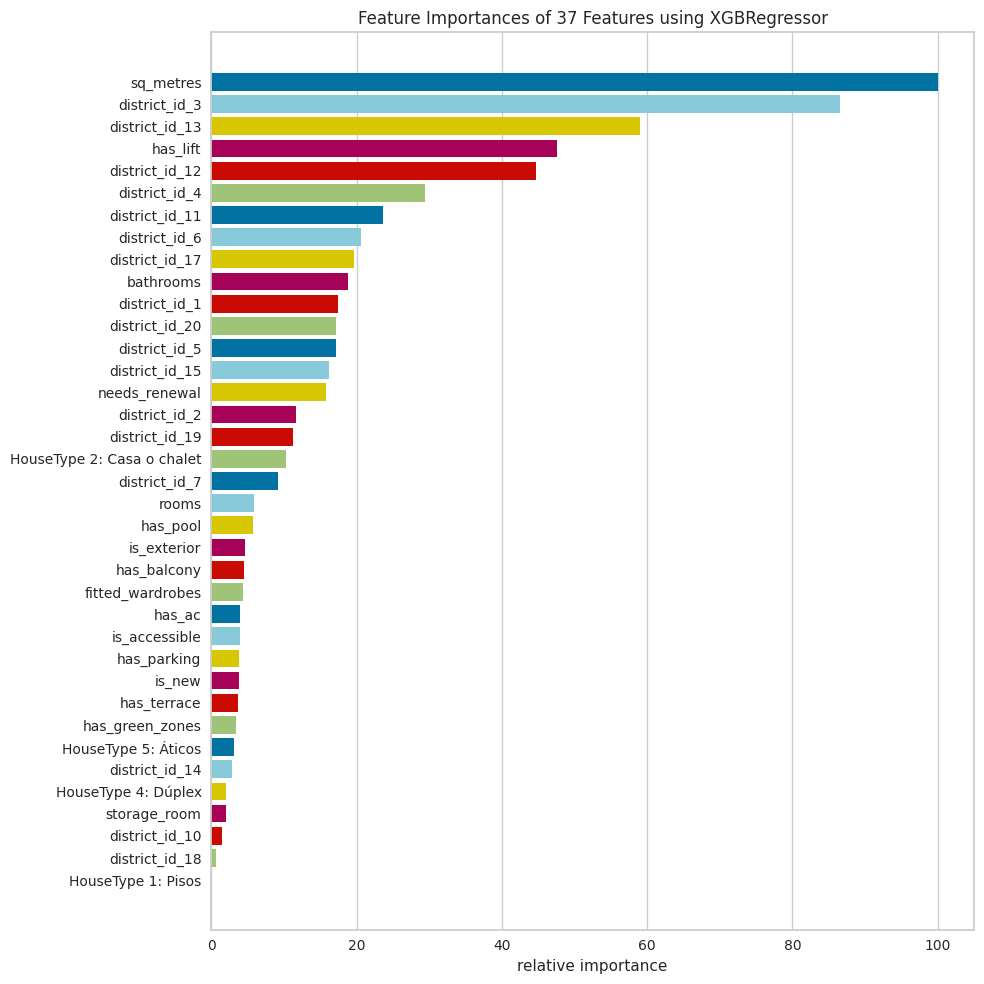

<AxesSubplot: title={'center': 'Feature Importances of 37 Features using XGBRegressor'}, xlabel='relative importance'>

In [86]:
#XGBRegressor, {'max_depth': 5, 'n_estimators': 100}:

XGBmodel=xgb.XGBRegressor(max_depth=5, n_estimators=100)
XGBmodel.fit(train_X_clean,train_y)

fig,ax=plt.subplots(figsize=(10,10))

XGB_viz=FeatureImportances(XGBmodel)
XGB_viz.fit(train_X,train_y)

XGB_viz.poof()

In [87]:
#HouseType 1: Pisos doesn't seem to have importance at all. We'll try trimming it:

train_X_XGB_trimmed = train_X_clean.drop(columns=["HouseType 1: Pisos"])

kfold_XGB_trim=model_selection.KFold(n_splits=10)

results__XGB_trim=model_selection.cross_validate(xgb.XGBRegressor(max_depth=5, n_estimators=100),train_X_XGB_trimmed,train_y,scoring=scores,cv=kfold_XGB_trim)

mse_XGB_trim=results__XGB_trim['test_neg_mean_squared_error'].mean()*-1
rmse_XGB_trim=math.sqrt(mse_XGB_trim)

print(
        f"XGB_trimmed "
        f"{results__XGB_trim['fit_time'].mean():.3f}s  R2: "
        f"{results__XGB_trim['test_r2'].mean():.3f}  MAE: "
        f"{results__XGB_trim['test_neg_mean_absolute_error'].mean()*-1:.3f}  RMSE: "
        f"{rmse_XGB_trim:.3f}"
    )

XGB_trimmed 0.539s  R2: 0.885  MAE: 121658.796  RMSE: 253455.599


In [88]:
#yup, R2 stays the same (0.885). Therefore, we are keeping train_X_XGB_trimmed.
#we can proceed to the final train for XGB:

remove_from_test_XGB = []

for col in test_X.columns:
    if col not in train_X_XGB_trimmed.columns:
        remove_from_test_XGB.append(col)

test_X_XGB = test_X.drop(columns=remove_from_test_XGB)
print(len(test_X_XGB.columns))
len(train_X_XGB_trimmed.columns)

36


36

In [89]:
#time to train XGB:

XGBmodel_final=xgb.XGBRegressor(max_depth=5, n_estimators=100)

XGBmodel_final.fit(train_X_XGB_trimmed,train_y)

XGBmodel_final.score(test_X_XGB,test_y)

0.8688847617008297

In [90]:
joblib.dump(XGBmodel_final, "model_realestate_XGB")


['model_realestate_XGB']

/tmp/ipykernel_32548/3634282877.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Randomodel.fit(train_X_nonna_clean,train_y)
/home/maria/.pyenv/versions/lewagon/envs/real_estate_env/lib/python3.8/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

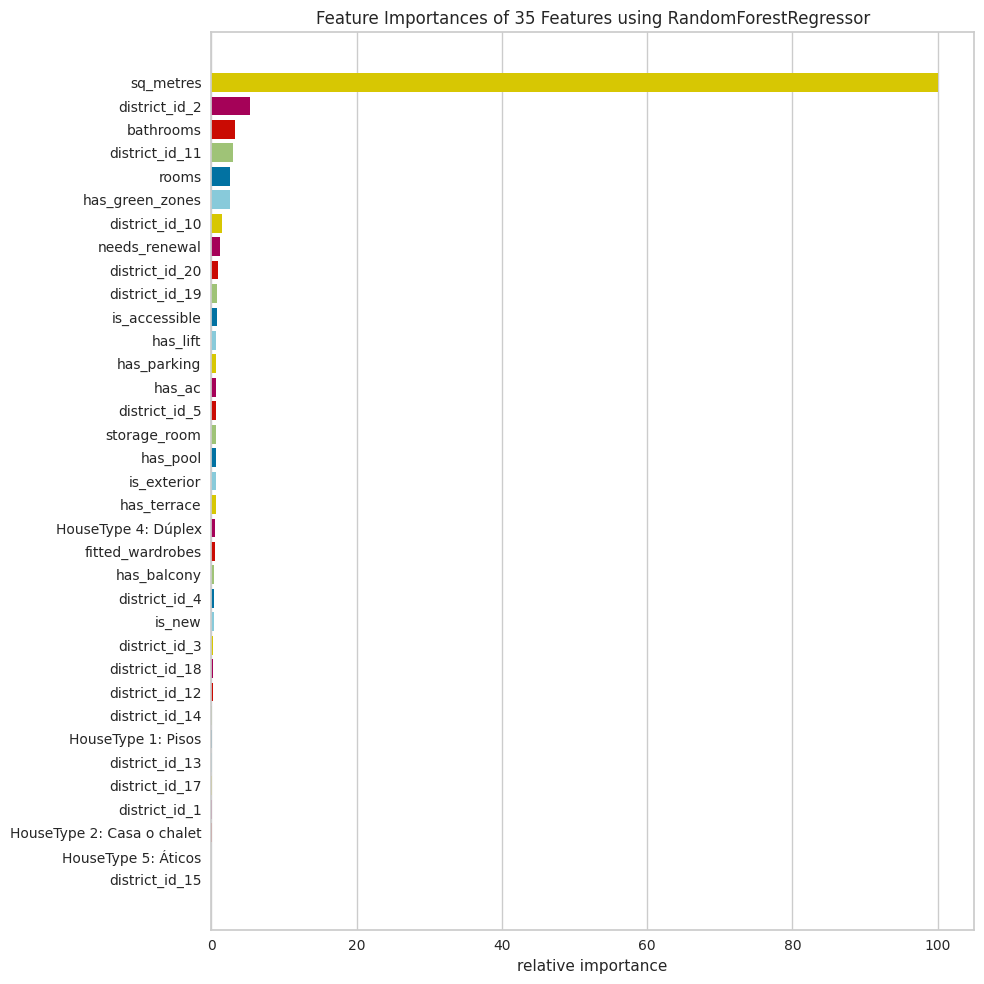

<AxesSubplot: title={'center': 'Feature Importances of 35 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [91]:
#and time to do the same for RandomForestRegressor, starting again at checking the feature importance
#using train_X_nonna_clean and {'n_estimators': 1000}

Randomodel=RandomForestRegressor(n_estimators=1000)
Randomodel.fit(train_X_nonna_clean,train_y)

fig,ax=plt.subplots(figsize=(10,10))

XGB_viz=FeatureImportances(Randomodel)
XGB_viz.fit(train_X,train_y)

XGB_viz.poof()

In [92]:
#there seems we could perfectly get rid of 8 columns:

train_X_random_trimmed = train_X_nonna_clean.drop(columns=['district_id_14','HouseType 1: Pisos','district_id_13','district_id_17','district_id_1','HouseType 2: Casa o chalet','HouseType 5: Áticos','district_id_15'])

remove_from_test_random = []

for col in test_X_nonna.columns:
    if col not in train_X_random_trimmed.columns:
        remove_from_test_random.append(col)

test_X_random = test_X_nonna.drop(columns=remove_from_test_random)
print(len(test_X_random.columns))
len(train_X_random_trimmed.columns)

27


27

In [94]:
#time to train RandomForestRegressor:

Randomodel_final=RandomForestRegressor(n_estimators=1000)

Randomodel_final.fit(train_X_random_trimmed,train_y)

Randomodel_final.score(test_X_random,test_y)

/tmp/ipykernel_32548/3125978722.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Randomodel_final.fit(train_X_random_trimmed,train_y)


0.8416407324549211

In [95]:
joblib.dump(Randomodel_final, "model_realestate_randomforest")
#in order to load: loaded_model = joblib.load("model_realestate_randomforest")

['model_realestate_randomforest']

In [127]:
#since XGB jas the biggest score, we'll use 'model_realestate_XGB' for our API. We'll keep the randomforest one in case it went extremely slow.
#for the 'model_realestate_XGB' to work, it need these columns:
columns_needed = test_X_XGB.columns
columns_needed

Index(['sq_metres', 'rooms', 'bathrooms', 'needs_renewal', 'is_new', 'has_ac',
       'fitted_wardrobes', 'has_lift', 'is_exterior', 'has_pool',
       'has_terrace', 'has_balcony', 'storage_room', 'is_accessible',
       'has_parking', 'HouseType 2: Casa o chalet', 'HouseType 5: Áticos',
       'district_id_1', 'district_id_10', 'district_id_11', 'district_id_12',
       'district_id_13', 'district_id_14', 'district_id_15', 'district_id_17',
       'district_id_18', 'district_id_19', 'district_id_2', 'district_id_20',
       'district_id_3', 'district_id_4', 'district_id_5', 'district_id_6',
       'district_id_7', 'district_id_8', 'district_id_9'],
      dtype='object')

In [99]:
loaded_model = joblib.load("model_realestate_XGB")
loaded_model.score(test_X_XGB,test_y)

0.8688847617008297

In [101]:
test_X_XGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4313 entries, 485 to 5736
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sq_metres                   4313 non-null   float64
 1   rooms                       4313 non-null   int64  
 2   bathrooms                   4313 non-null   float64
 3   needs_renewal               4313 non-null   bool   
 4   is_new                      4313 non-null   bool   
 5   has_ac                      4313 non-null   bool   
 6   fitted_wardrobes            4313 non-null   bool   
 7   has_lift                    3915 non-null   float64
 8   is_exterior                 3915 non-null   float64
 9   has_pool                    4313 non-null   bool   
 10  has_terrace                 4313 non-null   bool   
 11  has_balcony                 4313 non-null   bool   
 12  storage_room                4313 non-null   bool   
 13  is_accessible               431

In [102]:
prova=pd.read_csv('../raw_data/houses_Madrid.csv')

In [109]:
distritos_bruts = prova.neighborhood_id
for distrito in distritos_bruts.unique():
    print(distrito)

Neighborhood 135: San Cristóbal (1308.89 €/m2) - District 21: Villaverde
Neighborhood 132: Los Ángeles (1796.68 €/m2) - District 21: Villaverde
Neighborhood 134: San Andrés (1617.18 €/m2) - District 21: Villaverde
Neighborhood 133: Los Rosales (1827.79 €/m2) - District 21: Villaverde
Neighborhood 131: Butarque (2197.8 €/m2) - District 21: Villaverde
Neighborhood 127: Valdebernardo - Valderribas (2750.0 €/m2) - District 19: Vicálvaro
Neighborhood 124: Ambroz (2094.51 €/m2) - District 19: Vicálvaro
Neighborhood 125: Casco Histórico de Vicálvaro (2064.65 €/m2) - District 19: Vicálvaro
Neighborhood 126: El Cañaveral - Los Berrocales (2271.52 €/m2) - District 19: Vicálvaro
Neighborhood 128: Casco Histórico de Vallecas (1956.0 €/m2) - District 20: Villa de Vallecas
Neighborhood 129: Ensanche de Vallecas - La Gavia (2677.28 €/m2) - District 20: Villa de Vallecas
Neighborhood 130: Santa Eugenia (2175.93 €/m2) - District 20: Villa de Vallecas
Neighborhood 119: Orcasitas (1931.95 €/m2) - Distric

In [107]:
type(test_X_XGB)

pandas.core.frame.DataFrame

In [129]:
sq_metres=289
rooms=2
bathrooms=1
needs_renewal=False
is_new=False
has_ac=False
fitted_wardrobes=True
has_lift=True
is_exterior=False
has_pool=False
has_terrace=False
has_balcony=True
storage_room=False
is_accessible=False
has_parking=False
Casa=0
Aticos=0
district_id_1=1
district_id_10=0
district_id_11=0
district_id_12=0
district_id_13=0
district_id_14=0
district_id_15=0
district_id_17=0
district_id_18=0
district_id_19=0
district_id_2=0
district_id_20=0
district_id_3=0
district_id_4=0
district_id_5=0
district_id_6=0
district_id_7=0
district_id_8=0
district_id_9=0

In [130]:
llistota = [sq_metres, rooms, bathrooms, needs_renewal, is_new, has_ac,
                          fitted_wardrobes, has_lift, is_exterior, has_pool, has_terrace,
                          has_balcony, storage_room, is_accessible, has_parking,
                          Casa , Aticos, district_id_1, district_id_10, district_id_11,
                          district_id_12, district_id_13, district_id_14, district_id_15,
                          district_id_17, district_id_18, district_id_19, district_id_2,
                          district_id_20, district_id_3, district_id_4, district_id_5, district_id_6,
                          district_id_7, district_id_8, district_id_9]
llistota

[289,
 2,
 1,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [131]:
llistota_de_llistotes = [llistota]
llistota_de_llistotes

[[289,
  2,
  1,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]]

In [132]:
el_deefe = pd.DataFrame (llistota_de_llistotes, columns = ['sq_metres', 'rooms', 'bathrooms', 'needs_renewal', 'is_new', 'has_ac',
       'fitted_wardrobes', 'has_lift', 'is_exterior', 'has_pool',
       'has_terrace', 'has_balcony', 'storage_room', 'is_accessible',
       'has_parking', 'HouseType 2: Casa o chalet', 'HouseType 5: Áticos',
       'district_id_1', 'district_id_10', 'district_id_11', 'district_id_12',
       'district_id_13', 'district_id_14', 'district_id_15', 'district_id_17',
       'district_id_18', 'district_id_19', 'district_id_2', 'district_id_20',
       'district_id_3', 'district_id_4', 'district_id_5', 'district_id_6',
       'district_id_7', 'district_id_8', 'district_id_9'])
el_deefe

,sq_metres,rooms,bathrooms,needs_renewal,is_new,has_ac,fitted_wardrobes,has_lift,is_exterior,has_pool,...,district_id_19,district_id_2,district_id_20,district_id_3,district_id_4,district_id_5,district_id_6,district_id_7,district_id_8,district_id_9
0,289,2,1,False,False,False,True,True,False,False,...,0,0,0,0,0,0,0,0,0,0


In [133]:
loaded_model.predict(el_deefe)

array([1064327.8], dtype=float32)

In [134]:
loaded_model.predict(el_deefe)[0]

1064327.8

In [113]:
prova[:1]

,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,False,True,False,False


In [149]:
sorted(list(prova.n_bathrooms.unique()))

[1.0,
 2.0,
 3.0,
 4.0,
 6.0,
 nan,
 5.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0]